<a href="https://colab.research.google.com/github/HaywhyCoder/ACSC--Lizman/blob/main/loanCred_model_with_Indicators(Final_submission).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, f1_score

### Import Data

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Loan Credibility Notebooks/Train.csv")
data = dataset.copy()
data.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


In [ ]:
economic_indicators = pd.read_csv("/content/drive/MyDrive/Loan Credibility Notebooks/economic_indicators.csv", index_col="Country")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [ ]:
data.describe(include='all')

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
count,68654,68654.000000,68654,68654.000000,68654.000000,68654,6.865400e+04,6.865400e+04,68654,68654,68654.000000,68654,6.865400e+04,68654.000000,6.865400e+04,68654.000000
unique,68654,NaN,1,NaN,NaN,22,NaN,NaN,768,893,NaN,2,NaN,NaN,NaN,NaN
top,ID_249117268933267278,NaN,Kenya,NaN,NaN,Type_1,NaN,NaN,2022-07-16,2022-07-23,NaN,Repeat Loan,NaN,NaN,NaN,NaN
freq,1,NaN,68654,NaN,NaN,61723,NaN,NaN,938,940,NaN,68087,NaN,NaN,NaN,NaN
mean,NaN,254390.256780,NaN,263056.266248,266420.528462,NaN,1.483683e+04,1.563993e+04,NaN,NaN,8.544586,NaN,2.545663e+03,0.218679,2.652621e+03,0.018324
std,NaN,26642.719918,NaN,39486.661487,3590.999004,NaN,1.416499e+05,1.650784e+05,NaN,NaN,13.343145,NaN,1.192272e+04,0.129832,1.338006e+04,0.134120
min,NaN,145.000000,NaN,101323.000000,245684.000000,NaN,2.000000e+00,0.000000e+00,NaN,NaN,1.000000,NaN,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,NaN,248945.750000,NaN,233942.250000,267278.000000,NaN,2.295000e+03,2.329000e+03,NaN,NaN,7.000000,NaN,2.340000e+02,0.118712,2.390000e+02,0.000000
50%,NaN,255361.000000,NaN,260305.500000,267278.000000,NaN,5.249000e+03,5.325000e+03,NaN,NaN,7.000000,NaN,9.150000e+02,0.300000,9.340000e+02,0.000000
75%,NaN,262269.250000,NaN,286962.750000,267278.000000,NaN,1.145000e+04,1.165000e+04,NaN,NaN,7.000000,NaN,2.272650e+03,0.300000,2.317000e+03,0.000000


In [ ]:
b = ['Type_1', 'Type_7', 'Type_5', 'Type_4', 'Type_6', 'Type_14',
       'Type_9', 'Type_10', 'Type_19', 'Type_16', 'Type_2', 'Type_11',
       'Type_23', 'Type_18', 'Type_17', 'Type_12', 'Type_20', 'Type_13',
       'Type_21', 'Type_15', 'Type_24', 'Type_22']

In [ ]:
a = np.array(data['loan_type'].value_counts())
a = a.reshape(-1,1)

In [ ]:
defaulters_by_loan_type = data.groupby(['loan_type'])[['target']].sum()
c = defaulters_by_loan_type.loc[b]
c = np.array(c.values)

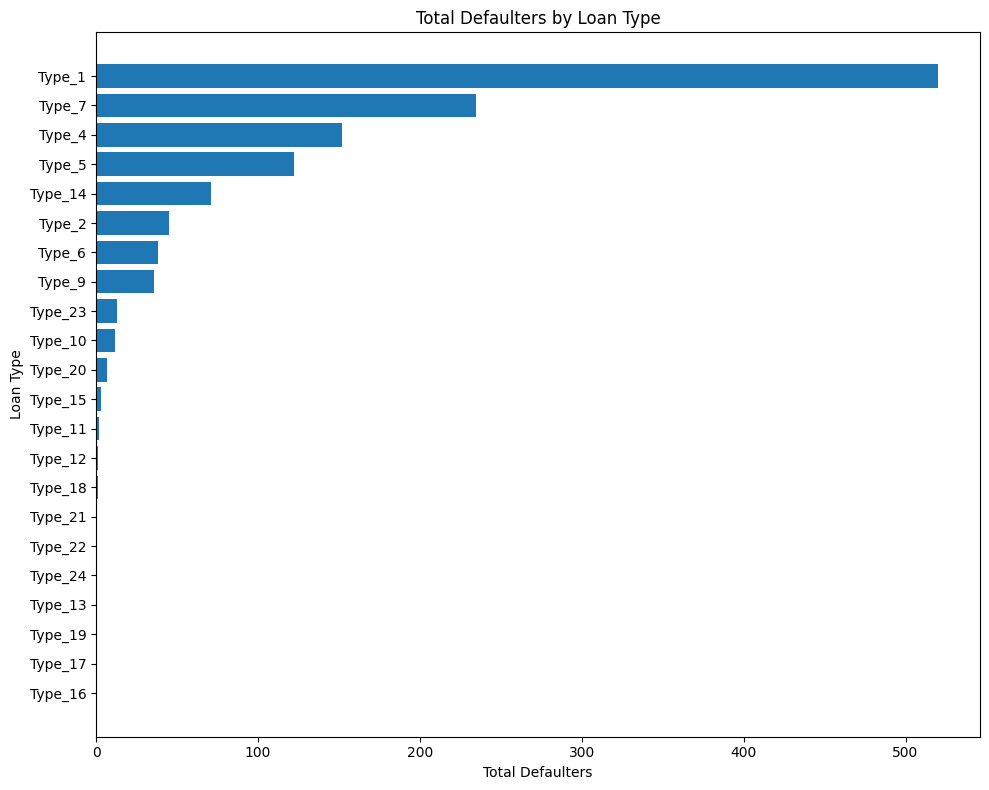

In [ ]:
defaultion_by_loan_type = pd.DataFrame(data=np.concatenate((a, c), axis=1), columns=['Loans', 'Defaulters'], index=data['loan_type'].unique()).sort_values(by="Defaulters")

plt.figure(figsize=(10, 8))
plt.barh(y=defaultion_by_loan_type.index, width=defaultion_by_loan_type['Defaulters'].values)
plt.title(f"Total Defaulters by Loan Type")
plt.ylabel("Loan Type")
plt.xlabel(f"Total Defaulters")

plt.tight_layout()
plt.show()

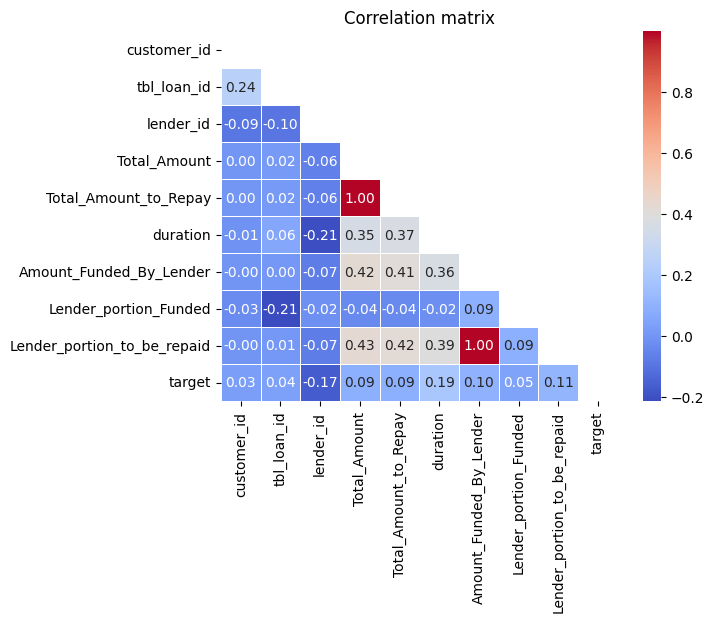

In [ ]:
corr_matrix = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.title("Correlation matrix")
plt.show()

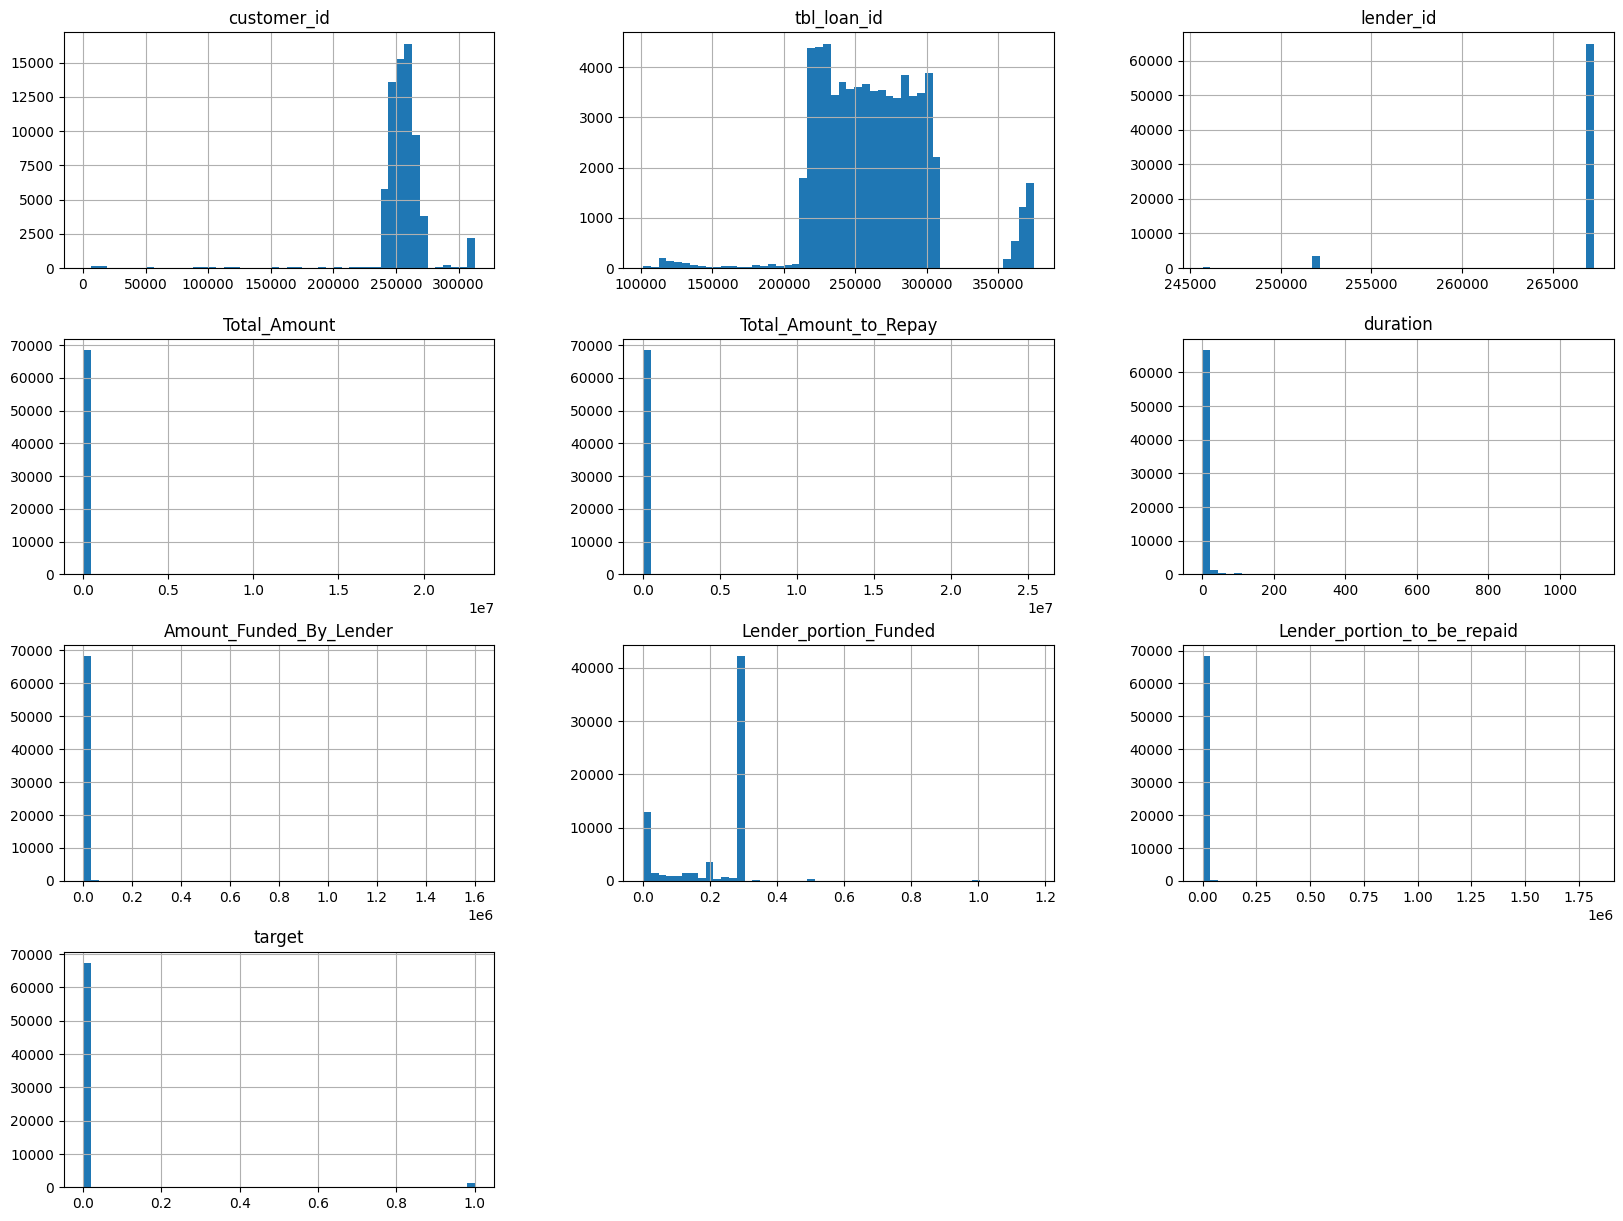

In [ ]:
%matplotlib inline
data.hist(bins=50, figsize=(20, 15))
plt.show()

### Feature Engineering

In [ ]:
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col])
    # data[col+'_month'] = data[col].dt.month
    # data[col+'_day'] = data[col].dt.day
    data[col+'_year'] = data[col].dt.year

In [ ]:
data['disbursement_date_year'].value_counts()

,count
disbursement_date_year,
2022,64405
2024,2970
2023,1240
2021,39


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           68654 non-null  object        
 1   customer_id                  68654 non-null  int64         
 2   country_id                   68654 non-null  object        
 3   tbl_loan_id                  68654 non-null  int64         
 4   lender_id                    68654 non-null  int64         
 5   loan_type                    68654 non-null  object        
 6   Total_Amount                 68654 non-null  float64       
 7   Total_Amount_to_Repay        68654 non-null  float64       
 8   disbursement_date            68654 non-null  datetime64[ns]
 9   due_date                     68654 non-null  datetime64[ns]
 10  duration                     68654 non-null  int64         
 11  New_versus_Repeat            68654 non-nu

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer



class CombinedAttrAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['Repayment_Ratio'] = X.loc[:,'Total_Amount_to_Repay'] / X.loc[:, 'Total_Amount']
        X['Funding_Gap'] = X.loc[:, 'Total_Amount'] - X.loc[:, 'Amount_Funded_By_Lender']
        X['Burden_Index'] = X.loc[:, 'Total_Amount_to_Repay'] / X.loc[:, 'duration']
        X['New_versus_Repeat'] = X['New_versus_Repeat'].map({'Repeat Loan': 1, 'New Loan': 0})
        return X

In [ ]:
def get_indicators(data,country):
    indicators = ['Inflation', 'Unemployment']
    indicator_by_year = []
    all_indicators = data.loc[country]
    for indicator in indicators:
        if indicator == 'Inflation':
            new = dict(all_indicators.iloc[0, :])
        else:
            new = dict(all_indicators.iloc[-1, :])
        new['Indicator'] = indicator
        indicator_by_year.append(new)
    return indicator_by_year

In [ ]:
def inflation(row):
    country = row['country_id']
    year = row['disbursement_date_year']
    indicator_by_year = get_indicators(economic_indicators, country)
    for indicator in indicator_by_year:
        if indicator['Indicator'] == 'Inflation':
            if year in [2024]:
                return  np.average(list(indicator.values())[1:-1])
            else:
                year = 'YR' + str(year)
                value = indicator.get(year)
                return value

In [ ]:
def unemployment_rate(row):
    country = row['country_id']
    year = row['disbursement_date_year']
    indicator_by_year = get_indicators(economic_indicators, country)
    for indicator in indicator_by_year:
        if indicator['Indicator'] == 'Unemployment':
            if year in [2024]:
                return  np.average(list(indicator.values())[1:-1])
            else:
                year = 'YR' + str(year)
                value = indicator.get(year)
                return value

In [ ]:
data['inflation'] = data.apply(inflation, axis=1)

In [ ]:
data['unemployment_rate'] = data.apply(unemployment_rate, axis=1)

In [ ]:
data.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,disbursement_date_year,due_date_year,inflation,unemployment_rate
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0,2022,2022,7.659863,5.805000
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0,2022,2022,7.659863,5.805000
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0,2024,2024,8.594715,3.376955
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0,2022,2022,7.659863,5.805000
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0,2022,2022,7.659863,5.805000


In [ ]:
data.columns

Index(['ID', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id',
       'loan_type', 'Total_Amount', 'Total_Amount_to_Repay',
       'disbursement_date', 'due_date', 'duration', 'New_versus_Repeat',
       'Amount_Funded_By_Lender', 'Lender_portion_Funded',
       'Lender_portion_to_be_repaid', 'target', 'disbursement_date_year',
       'due_date_year', 'inflation', 'unemployment_rate'],
      dtype='object')

In [ ]:
num_data = [col for col in data.select_dtypes(include='number').columns if col not  in ['target']]
num_data

['customer_id',
 'tbl_loan_id',
 'lender_id',
 'Total_Amount',
 'Total_Amount_to_Repay',
 'duration',
 'Amount_Funded_By_Lender',
 'Lender_portion_Funded',
 'Lender_portion_to_be_repaid',
 'disbursement_date_year',
 'due_date_year',
 'inflation',
 'unemployment_rate']

In [ ]:
cat_data = [col for col in data.select_dtypes(include='object').columns if col not in ['ID']]
cat_data

['country_id', 'loan_type', 'New_versus_Repeat']

### Splitting the Train data

In [ ]:
#Checkpoint
train_data = data.copy()

In [ ]:
attr_adder = CombinedAttrAdder()
train_data = attr_adder.transform(train_data)
train_data.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,...,Lender_portion_Funded,Lender_portion_to_be_repaid,target,disbursement_date_year,due_date_year,inflation,unemployment_rate,Repayment_Ratio,Funding_Gap,Burden_Index
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,...,0.014305,121.0,0,2022,2022,7.659863,5.805000,1.000000,8327.15,1206.857143
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,...,0.300000,7794.0,0,2022,2022,7.659863,5.805000,1.003244,18126.50,3711.285714
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,...,0.200000,1428.0,0,2024,2024,8.594715,3.376955,1.035072,5520.00,1020.285714
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,...,0.300000,2770.0,0,2022,2022,7.659863,5.805000,1.030699,6270.60,1319.000000
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,...,0.300000,1418.0,0,2022,2022,7.659863,5.805000,1.035933,3194.80,675.428571


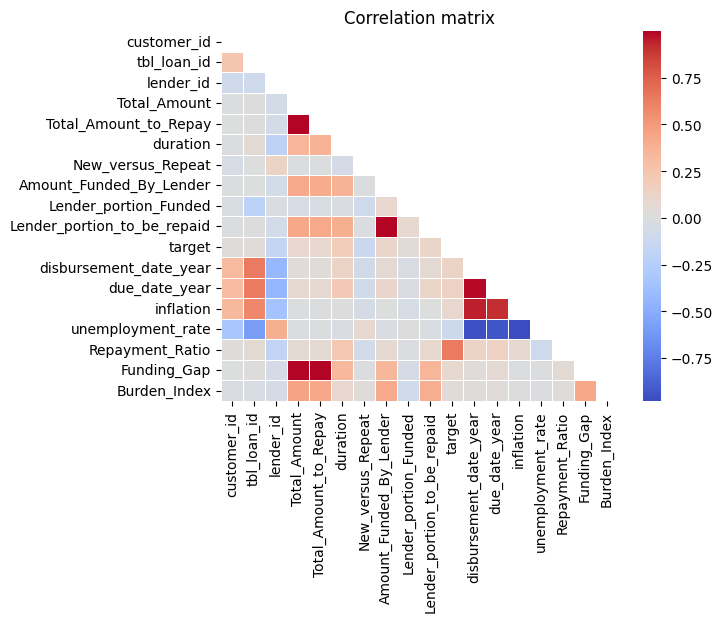

In [ ]:
corr_matrix = train_data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.title("Correlation matrix")
plt.show()

In [ ]:
corr_matrix = train_data.corr(numeric_only=True)
corr_matrix['target'].sort_values(ascending=False)

,target
target,1.000000
Repayment_Ratio,0.636974
duration,0.189889
due_date_year,0.143727
disbursement_date_year,0.129514
Lender_portion_to_be_repaid,0.109517
Amount_Funded_By_Lender,0.101845
inflation,0.089741
Total_Amount_to_Repay,0.087089
Total_Amount,0.086043


In [ ]:
X = train_data.drop('target', axis=1)
y = train_data['target']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)
X_train.shape

(54923, 22)

In [ ]:
y_train.value_counts()

,count
target,
0,53917
1,1006


### Building the Training Pipeline

In [ ]:
data_num = ['duration','Lender_portion_to_be_repaid', 'Repayment_Ratio', 'Funding_Gap', 'inflation', 'unemployment_rate']

pipeline = ColumnTransformer([
    ('num', StandardScaler(), data_num),
    ("cat", OneHotEncoder(handle_unknown='ignore'), ['loan_type']),
    ('cat1', 'passthrough', ['New_versus_Repeat'])
], sparse_threshold=0)
full_pipeline = Pipeline([
    ('preprocess', pipeline),
    ('classifier', RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5, n_estimators=200, class_weight={0: 0.5821105527638191, 1: 0.41788944723618093},random_state=42)),
])

### Training Loop

In [ ]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num', StandardScaler(),
                                                  ['duration',
                                                   'Lender_portion_to_be_repaid',
                                                   'Repayment_Ratio',
                                                   'Funding_Gap', 'inflation',
                                                   'unemployment_rate']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['loan_type']),
                                                 ('cat1', 'passthrough',
                                                  ['New_versus_Repeat'])])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight={0: 0.5821105527638191,
                                                      1: 0.41788944723618093},
                                        max_depth=30, min_samples_split=5,
                                        n_estimators=200, random_state=42))])

In [ ]:
y_pred = full_pipeline.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53917
           1       1.00      0.99      1.00      1006

    accuracy                           1.00     54923
   macro avg       1.00      1.00      1.00     54923
weighted avg       1.00      1.00      1.00     54923



In [ ]:
val_pred = full_pipeline.predict(X_val)
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.89      0.86      0.88       252

    accuracy                           1.00     13731
   macro avg       0.94      0.93      0.94     13731
weighted avg       1.00      1.00      1.00     13731



In [ ]:
pipeline.get_feature_names_out()

array(['num__duration', 'num__Lender_portion_to_be_repaid',
       'num__Repayment_Ratio', 'num__Funding_Gap', 'num__inflation',
       'num__unemployment_rate', 'cat__loan_type_Type_1',
       'cat__loan_type_Type_10', 'cat__loan_type_Type_11',
       'cat__loan_type_Type_12', 'cat__loan_type_Type_13',
       'cat__loan_type_Type_14', 'cat__loan_type_Type_15',
       'cat__loan_type_Type_16', 'cat__loan_type_Type_17',
       'cat__loan_type_Type_18', 'cat__loan_type_Type_19',
       'cat__loan_type_Type_2', 'cat__loan_type_Type_20',
       'cat__loan_type_Type_21', 'cat__loan_type_Type_23',
       'cat__loan_type_Type_24', 'cat__loan_type_Type_4',
       'cat__loan_type_Type_5', 'cat__loan_type_Type_6',
       'cat__loan_type_Type_7', 'cat__loan_type_Type_9',
       'cat1__New_versus_Repeat'], dtype=object)

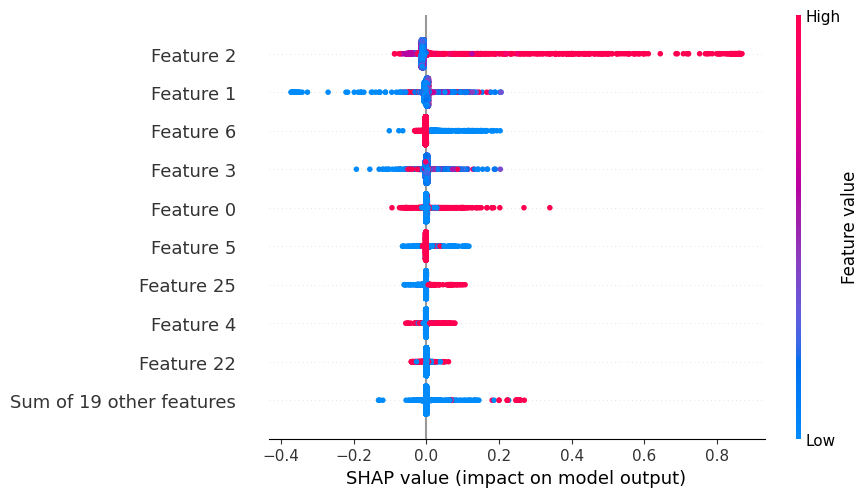

In [ ]:
rf_explainer =shap.Explainer(full_pipeline["classifier"])
shap_values = rf_explainer(full_pipeline["preprocess"].transform(X_val))

shap_values_class1 = shap_values[..., 1]
shap.plots.beeswarm(shap_values_class1)

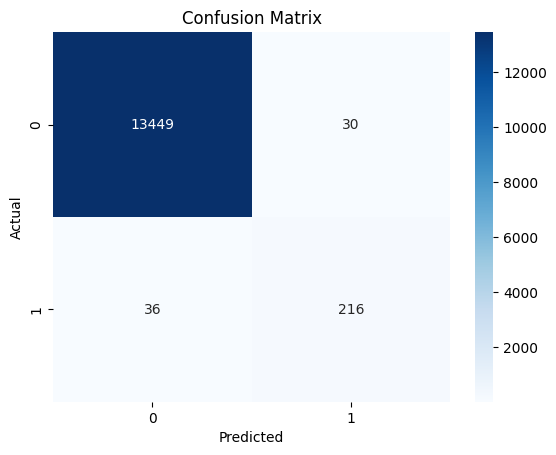

In [ ]:
conf_matrix = confusion_matrix(y_val, val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show

### Threshold Tuning

In [ ]:
y_pred_proba = pd.Series(full_pipeline.predict_proba(X_val)[:, 1])

In [ ]:
def tune_treshold(proba,threshold):
  if proba>threshold:
    return 1
  else:
    return 0

In [ ]:
threshold_range=np.arange(0,1,0.01)
f1_scores=[]
for i in threshold_range:
  tuned_predictions=y_pred_proba.apply(tune_treshold,args=(i,))
  f1_scores.append(f1_score(tuned_predictions,y_val))

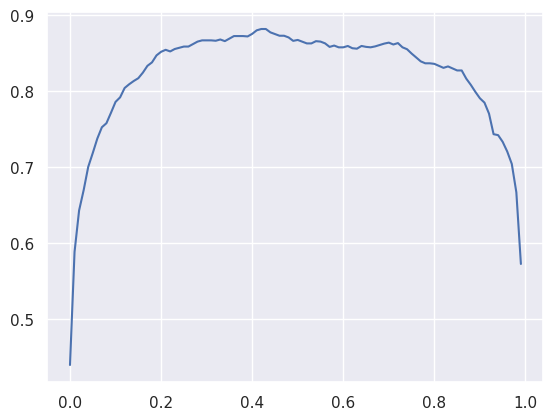

In [ ]:
plt.plot(threshold_range,f1_scores)

In [ ]:
threshold_range=np.arange(0.3,.485,0.0001)
f1_scores=[]
for i in threshold_range:
  tuned_predictions=y_pred_proba.apply(tune_treshold,args=(i,))
  f1_scores.append(f1_score(tuned_predictions,y_val))

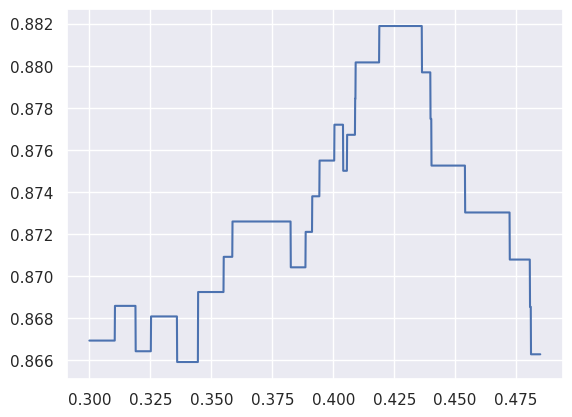

In [ ]:
plt.plot(threshold_range,f1_scores)

In [ ]:
best_treshold = threshold_range[np.argmax(f1_scores)]
best_treshold

0.4188999999999869

In [ ]:
print(classification_report(y_val, y_pred_proba.apply(tune_treshold,args=(best_treshold,))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.88      0.89      0.88       252

    accuracy                           1.00     13731
   macro avg       0.94      0.94      0.94     13731
weighted avg       1.00      1.00      1.00     13731



In [ ]:
print(f"Your validation f1_score is {f1_score(y_pred_proba.apply(tune_treshold,args=(best_treshold,)),y_val)}")

Your validation f1_score is 0.8818897637795275


### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

weights = np.linspace(0.0, 0.99,200)

param_grid = {
    'class_weight': [{0:1.0-x, 1:x} for x in weights]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    random_state=42,
)

random_search.fit(full_pipeline['preprocess'].fit_transform(X_train), y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'class_weight': [{0: 1.0, 1: 0.0},
                                                         {0: 0.9950251256281407,
                                                          1: 0.004974874371859297},
                                                         {0: 0.9900502512562814,
                                                          1: 0.009949748743718593},
                                                         {0: 0.9850753768844221,
                                                          1: 0.014924623115577889},
                                                         {0: 0.9801005...
                                                         {0: 0.8855778894472361,
                                                          1: 0.11442211055276383},
                                                         {0: 0.8806030150753769,
                                                          1: 0.11939698492462311},
                                                         {0: 0.8756281407035176,
                                                          1: 0.12437185929648241},
                                                         {0: 0.8706532663316583,
                                                          1: 0.1293467336683417},
                                                         {0: 0.865678391959799,
                                                          1: 0.13432160804020102},
                                                         {0: 0.8607035175879397,
                                                          1: 0.1392964824120603},
                                                         {0: 0.8557286432160804,
                                                          1: 0.1442713567839196}, ...]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
best_estimator = random_search.best_estimator_
best_estimator

RandomForestClassifier(class_weight={0: 0.5821105527638191,
                                     1: 0.41788944723618093},
                       random_state=42)

In [ ]:
val_pred = best_estimator.predict(full_pipeline['preprocess'].transform(X_val))
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.87      0.86      0.86       252

    accuracy                           1.00     13731
   macro avg       0.93      0.93      0.93     13731
weighted avg       1.00      1.00      1.00     13731



### Feature Importance

In [ ]:
features = pipeline.get_feature_names_out()
features

array(['num__duration', 'num__Lender_portion_to_be_repaid',
       'num__Repayment_Ratio', 'num__Burden_Index', 'num__Funding_Gap',
       'num__inflation', 'num__unemployment_rate',
       'cat__loan_type_Type_1', 'cat__loan_type_Type_10',
       'cat__loan_type_Type_11', 'cat__loan_type_Type_12',
       'cat__loan_type_Type_13', 'cat__loan_type_Type_14',
       'cat__loan_type_Type_15', 'cat__loan_type_Type_16',
       'cat__loan_type_Type_17', 'cat__loan_type_Type_18',
       'cat__loan_type_Type_19', 'cat__loan_type_Type_2',
       'cat__loan_type_Type_20', 'cat__loan_type_Type_21',
       'cat__loan_type_Type_23', 'cat__loan_type_Type_24',
       'cat__loan_type_Type_4', 'cat__loan_type_Type_5',
       'cat__loan_type_Type_6', 'cat__loan_type_Type_7',
       'cat__loan_type_Type_9', 'cat1__New_versus_Repeat'], dtype=object)

In [ ]:
feature_importance = full_pipeline['classifier'].feature_importances_
feature_importance

array([3.77528654e-02, 1.17048746e-01, 5.87591663e-01, 8.20838758e-02,
       8.42896071e-02, 8.73513552e-03, 7.24578042e-03, 1.92085083e-02,
       9.46164550e-04, 2.45083061e-03, 1.52426455e-04, 1.10542586e-05,
       1.06685463e-02, 2.74628837e-04, 1.04682255e-05, 4.51131921e-05,
       1.53417828e-04, 6.04163694e-04, 8.39874875e-03, 7.54563426e-04,
       5.56970852e-06, 3.04136933e-03, 4.10781831e-06, 8.03591077e-03,
       4.69751913e-03, 8.60033544e-04, 5.83706534e-03, 1.82050269e-03,
       7.27161374e-03])

In [ ]:
f_importance = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
f_importance.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
2,num__Repayment_Ratio,0.587592
1,num__Lender_portion_to_be_repaid,0.117049
4,num__Funding_Gap,0.084290
3,num__Burden_Index,0.082084
0,num__duration,0.037753
7,cat__loan_type_Type_1,0.019209
12,cat__loan_type_Type_14,0.010669
5,num__inflation,0.008735
18,cat__loan_type_Type_2,0.008399
23,cat__loan_type_Type_4,0.008036


### Testing the Model

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/Loan Credibility Notebooks/Test.csv")
test_data.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


In [ ]:
test = test_data.copy()

In [ ]:
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
    test[col] = pd.to_datetime(test[col])
    # data[col+'_month'] = data[col].dt.month
    # data[col+'_day'] = data[col].dt.day
    test[col+'_year'] = test[col].dt.year

In [ ]:
test['inflation'] = test.apply(inflation, axis=1)
test['unemployment_rate'] = test.apply(unemployment_rate, axis=1)

In [ ]:
test_prepd = attr_adder.transform(test)
test_prepd.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,...,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,disbursement_date_year,due_date_year,inflation,unemployment_rate,Repayment_Ratio,Funding_Gap,Burden_Index
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,...,575.7,0.300000,597.0,2022,2022,7.659863,5.805,1.036477,1343.3,284.142857
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,...,0.0,0.000000,0.0,2022,2022,7.659863,5.805,1.007016,2138.0,307.571429
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,...,207.0,0.025079,208.0,2022,2022,7.659863,5.805,1.006058,8047.0,1186.285714
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,...,1013.7,0.300000,1014.0,2022,2022,7.659863,5.805,1.000000,2365.3,482.714286
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,...,36.0,0.300000,36.0,2022,2022,7.659863,5.805,1.000000,84.0,17.142857


In [ ]:
y_test = full_pipeline.predict_proba(test_prepd)[:, 1]
# y_test = full_pipeline.predict(test_prepd)

In [ ]:
test_data['target'] = y_test
sub = test_data[['ID', 'target']]
sub["target"]= sub["target"].apply(tune_treshold,args=(best_treshold,))
sub.head()

<ipython-input-120-7cb9d339d524>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["target"]= sub["target"].apply(tune_treshold,args=(best_treshold,))


,ID,target
0,ID_269404226088267278,0
1,ID_255356300042267278,0
2,ID_257026243764267278,0
3,ID_264617299409267278,0
4,ID_247613296713267278,0


In [ ]:
sub.to_csv('submission.csv', index=False)

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

,ID,target
0,ID_269404226088267278,0
1,ID_255356300042267278,0
2,ID_257026243764267278,0
3,ID_264617299409267278,0
4,ID_247613296713267278,0


In [ ]:
sub['target'].value_counts()

,count
target,
0,17934
1,660


In [ ]:
sub['target'].value_counts()

,count
target,
0,17953
1,641
